# Evaluate

In this notebook we evaluate the accuracy of the predicted alignments.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [3]:
ANNOTATIONS_ROOT = Path('/data/Datasets/Chopin_Mazurkas/annotations_beat')
query_list = Path('cfg_files/query.test.list')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [4]:
def eval_dir(hypdir, querylist, hop_sec, savefile = None):
    
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [5]:
def eval_file(hypfile, hop_sec):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (ANNOTATIONS_ROOT / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (ANNOTATIONS_ROOT / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [6]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [7]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [8]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Debugging

In [9]:
hypdir = 'experiments_train/ssdtw_8_clean'
with open(query_list, 'r') as f:
    for line in f:
        parts = line.strip().split()
        assert len(parts) == 2
        basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
        hypfile = hypdir + '/' + basename + '.pkl'
        hypalign = loadAlignment(hypfile)
        if hypalign is None:
            print("None: ", hypfile)
        elif hypalign.shape[1] == 8:
            print(hypfile)
            break

FileNotFoundError: [Errno 2] No such file or directory: 'experiments_train/ssdtw_8_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ax-1985_pid9179-07.pkl'

Evaluate a single hypothesis directory.

In [10]:
hypdir = 'experiments_train/wsdtw_2_clean'
savefile = 'evaluations_train/wsdtw_2_clean.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Processing experiments_train/wsdtw_2_clean ... done


In [11]:
hypdir = 'experiments_train/ssdtw_8_clean'
savefile = 'evaluations_train/ssdtw_8_clean.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Processing experiments_train/ssdtw_8_clean ... done


Evaluate all hypothesis directories.

In [10]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for hypdir in glob.glob(f'{rootdir}/*'):
        savefile = outdir + '/' + os.path.basename(hypdir) + '.pkl'
        allErrs = eval_dir(hypdir, querylist, hop_sec, savefile = savefile)

In [11]:
EXPERIMENTS_ROOT = 'experiments_test/clean'
hop_sec = 512 * 1 / 22050
outdir = 'evaluations_test/clean'
eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

Processing experiments_test/clean/dtw ............... done
Processing experiments_test/clean/nsdtw_2 ............... done
Processing experiments_test/clean/nsdtw_4 ............... done
Processing experiments_test/clean/nsdtw_8 ............... done
Processing experiments_test/clean/nsdtw_16 ............... done
Processing experiments_test/clean/nsdtw_32 ............... done
Processing experiments_test/clean/wsdtw_2 ............... done
Processing experiments_test/clean/wsdtw_4 ............... done
Processing experiments_test/clean/wsdtw_8 ............... done
Processing experiments_test/clean/wsdtw_16 ............... done
Processing experiments_test/clean/wsdtw_32 ............... done
Processing experiments_test/clean/ssdtw_2 ............... done
Processing experiments_test/clean/ssdtw_4 ............... done
Processing experiments_test/clean/ssdtw_8 ............... done
Processing experiments_test/clean/ssdtw_16 ............... done
Processing experiments_test/clean/ssdtw_32 ...........

### Plot error vs tolerance

In [9]:
def calc_error_rates(errFile, maxTol):
    
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [10]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [11]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

In [12]:
EVAL_ROOT_DIR = 'evaluations_test/clean'

toPlot = ['dtw',
          'nsdtw_2', 'nsdtw_4', 'nsdtw_8', 'nsdtw_16', 'nsdtw_32', \
          'wsdtw_2', 'wsdtw_4', 'wsdtw_8', 'wsdtw_16', 'wsdtw_32', \
          'ssdtw_2', 'ssdtw_4', 'ssdtw_8', 'ssdtw_16', 'ssdtw_32']


# toPlot = ['ssdtw_2_clean', 'ssdtw_4_clean', 'ssdtw_8_clean', 'ssdtw_16_clean', 'ssdtw_32_clean', \
#           'ssdtw_cython_2_clean', 'ssdtw_cython_4_clean', 'ssdtw_cython_8_clean', 'ssdtw_cython_16_clean', 'ssdtw_cython_32_clean']

#toPlot = ['ssdtw_2_clean', 'ssdtw_test4_2_clean', 'ssdtw_cython_2_clean']
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates ................ done


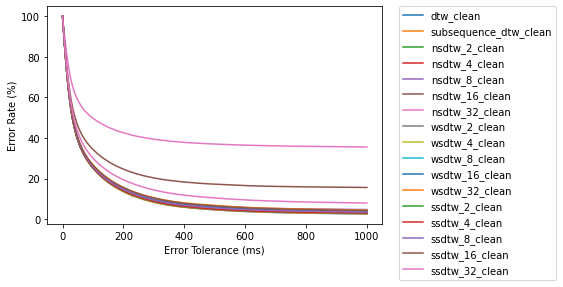

In [16]:
plot_multiple_roc(errRates, toPlot)

### Histogram of selected error rates

In [17]:
def plot_grouped_histogram1(errRates, basenames, tols):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return

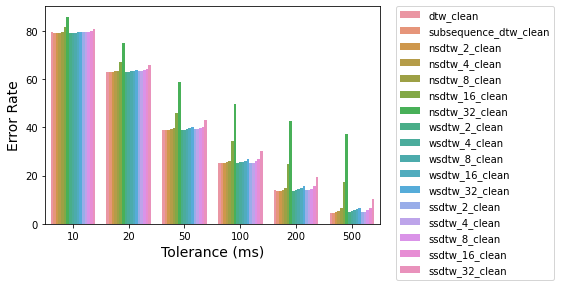

In [18]:
tols = [10, 20, 50, 100, 200, 500] # in msec
plot_grouped_histogram1(errRates, toPlot, tols)

### Final results plot for paper

This one is touched up to look nicer.

In [14]:
def plot_grouped_histogram1(errRates_bars, SSDTW_errRates, NSDTW_errRates, basenames, tols, savefile = None):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates_bars[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot (DTW & WSDTW)
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate (%)", size=14)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='upper right')
    
    plt.title("Alignment Error Rates for DTW, WSDTW, NSDTW, and SSDTW")
    
    # overlay dots for SSDTW results
    width_bar = .135
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(SSDTW_errRates.shape[0]):
            x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(SSDTW_errRates[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'ko', markersize=3)
    
    # overlay dots for NSDTW results
    width_bar = .135
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(NSDTW_errRates.shape[0]):
            x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(NSDTW_errRates[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'rx', markersize=3)
    
    if savefile:
        plt.savefig(savefile, bbox_inches = 'tight')
    
    return

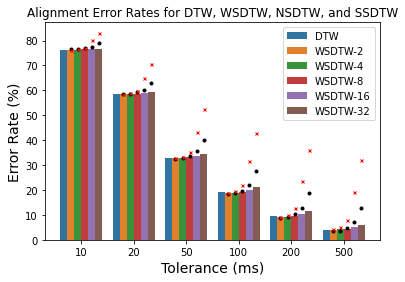

In [15]:
tols = [10, 20, 50, 100, 200, 500] # in msec
display_names = ['DTW', 'WSDTW-2', 'WSDTW-4', 'WSDTW-8', 'WSDTW-16','WSDTW-32']
savefile = 'results_test.png'
barRates = np.zeros((6, errRates.shape[1]))
barRates[0,:] = errRates[0,:]
barRates[1:, :] = errRates[6:11,:]
NSDTW_errRates = errRates[1:6,:]
SSDTW_errRates = errRates[11:,:]
plot_grouped_histogram1(barRates, SSDTW_errRates, NSDTW_errRates, display_names, tols, savefile)

## Noisy Data Plot

In [16]:
SNR_Vals = [20, 15, 10, 5, 0, -5, -10]

In [19]:
for SNR in SNR_Vals:
    EXPERIMENTS_ROOT = 'experiments_test/noisy_%sdB' % str(SNR)
    hop_sec = 512 * 1 / 22050
    outdir = 'evaluations_test/noisy_%sdB' % str(SNR)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

Processing experiments_test/noisy_20dB/DTW ............... done
Processing experiments_test/noisy_20dB/WSDTW_2 ............... done
Processing experiments_test/noisy_20dB/WSDTW_4 ............... done
Processing experiments_test/noisy_20dB/WSDTW_8 ............... done
Processing experiments_test/noisy_20dB/WSDTW_16 ............... done
Processing experiments_test/noisy_20dB/WSDTW_32 ............... done
Processing experiments_test/noisy_15dB/DTW ............... done
Processing experiments_test/noisy_15dB/WSDTW_2 ............... done
Processing experiments_test/noisy_15dB/WSDTW_4 ............... done
Processing experiments_test/noisy_15dB/WSDTW_8 ............... done
Processing experiments_test/noisy_15dB/WSDTW_16 ............... done
Processing experiments_test/noisy_15dB/WSDTW_32 ............... done
Processing experiments_test/noisy_10dB/DTW ............... done
Processing experiments_test/noisy_10dB/WSDTW_2 ............... done
Processing experiments_test/noisy_10dB/WSDTW_4 .........

In [17]:
errRates100 = np.zeros((7, 6)) # Each row is a different SNR, each col is a different system
errRates20 = np.zeros((7, 6))
errRates500 = np.zeros((7, 6))
toPlot = ["DTW", "WSDTW_2", "WSDTW_4", "WSDTW_8", "WSDTW_16", "WSDTW_32"]

for i, SNR in enumerate(SNR_Vals):
    EVAL_ROOT_DIR = 'evaluations_train/noisy_%sdB' % str(SNR)
    
    maxTol = 1000 # in msec
    theseErrRates, _ = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)
    for j in range(len(toPlot)):
        errRates100[i, j] = theseErrRates[j, 100]
        errRates20[i, j] = theseErrRates[j, 20]
        errRates500[i, j] = theseErrRates[j, 500]

Computing error rates ...... done
Computing error rates ...... done
Computing error rates ...... done
Computing error rates ...... done
Computing error rates ...... done
Computing error rates ...... done
Computing error rates ...... done


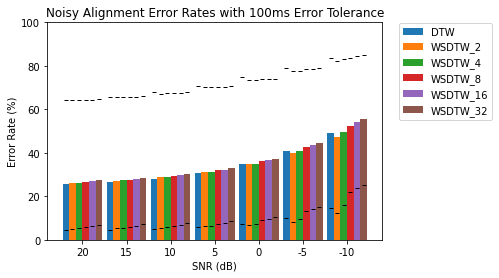

In [21]:
x_coords = []
y_coords20 = []
y_coords500 = []
for i in range(len(toPlot)):
    width = 0.15
    plt.bar(np.arange(7)+i * width, errRates100[:,i] * 100, width);
    
    plt.title("Noisy Alignment Error Rates with 100ms Error Tolerance");
    plt.legend(toPlot, loc = (1.05,0.55));

    plt.ylim([0,100]);
    plt.ylabel("Error Rate (%)")
    
    plt.xlabel("SNR (dB)")
    plt.xticks(np.arange(7) + 2.5 * width, SNR_Vals);
    
    x_coords.append(np.arange(7) + i * width)
    y_coords20.append(errRates20[:,i] * 100)
    y_coords500.append(errRates500[:,i] * 100)

plt.plot(x_coords, y_coords20, 'k_', markersize=4);
plt.plot(x_coords, y_coords500, 'k_', markersize=4);

In [17]:
errRates100[:,0]

array([0.25759258, 0.26564958, 0.27911156, 0.30548182, 0.34658185,
       0.40928108, 0.49336086])

### Runtime Analysis

In [18]:
dtw_runtimes, dtw_sizes = pickle.load(open('profiles/cython/dtw_prof.pkl', 'rb'))
# dtwV2_runtimes, dtwV2_sizes = pickle.load(open('profiles/cython/dtw_V2_prof.pkl', 'rb'))
#subsequence_dtw_runtimes, subsequence_dtw_sizes = pickle.load(open('profiles/subsequence_dtw_prof.pkl', 'rb'))
nsdtw_runtimes, nsdtw_segments, nsdtw_sizes = pickle.load(open('profiles/cython/nsdtw_prof.pkl', 'rb'))
wsdtw_runtimes, wsdtw_segments, wsdtw_sizes = pickle.load(open('profiles/cython/wsdtw_prof.pkl', 'rb'))
ssdtw_runtimes, ssdtw_segments, ssdtw_sizes = pickle.load(open('profiles/cython/ssdtw_prof.pkl', 'rb'))

Numbers for runtime table

In [19]:
dtw_avgs = np.mean(np.sum(dtw_runtimes[::-1,:,:], axis=2), axis=1)

In [20]:
# dtwV2_avgs = np.mean(np.sum(dtwV2_runtimes[::-1,:,:], axis=2), axis=1)

In [21]:
#subsequence_dtw_avgs = np.mean(np.sum(subsequence_dtw_runtimes[::-1,:,:], axis=2), axis=1)

In [22]:
nsdtw_avgs = np.mean(np.sum(nsdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [23]:
wsdtw_avgs = np.mean(np.sum(wsdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [24]:
ssdtw_avgs = np.mean(np.sum(ssdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [25]:
all_avgs = np.vstack((dtw_avgs.reshape((1,-1)), \
                     nsdtw_avgs, wsdtw_avgs, ssdtw_avgs))

In [26]:
# first row: DTW
# second row: subsequence DTW
# next 5 rows: NSDTW with segments = 2, 4, 8, 16, 32
# next 5 rows: WSDTW with segments = 2, 4, 8, 16, 32
# next 5 rows: SSDTW with segments = 2, 4, 8, 16, 32
all_avgs

array([[1.58510208e-02, 8.63675833e-02, 5.73020697e-01, 2.35682046e+00,
        9.55034041e+00, 6.05973853e+01],
       [1.62409306e-02, 1.10117364e-01, 5.79812980e-01, 2.28643003e+00,
        9.38916934e+00, 5.79352327e+01],
       [1.55390501e-02, 8.26524973e-02, 5.84822941e-01, 2.30329638e+00,
        9.41872907e+00, 6.03684434e+01],
       [1.43691301e-02, 8.09404135e-02, 4.91875792e-01, 2.24037914e+00,
        9.33337524e+00, 5.76189596e+01],
       [1.47613049e-02, 7.35070705e-02, 5.01411819e-01, 2.32152879e+00,
        9.56253698e+00, 5.86972303e+01],
       [1.63152218e-02, 7.47969389e-02, 4.89341235e-01, 1.95139174e+00,
        9.57530415e+00, 5.95461876e+01],
       [1.63762808e-02, 8.54364395e-02, 5.72295284e-01, 2.37596192e+00,
        9.42137468e+00, 5.69792812e+01],
       [1.44864559e-02, 7.69767761e-02, 5.65903759e-01, 2.27941942e+00,
        9.49085891e+00, 5.77485248e+01],
       [1.50131941e-02, 8.16477060e-02, 4.97606659e-01, 2.38122675e+00,
        9.60870357e+00, 

In [27]:
all_avgs.shape

(16, 6)

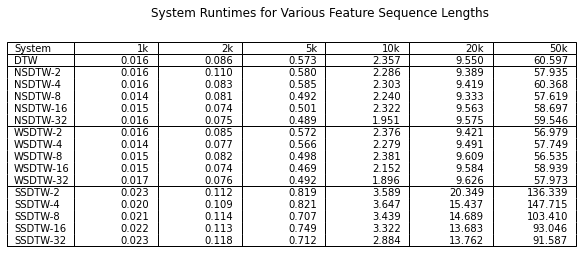

In [58]:
columns = ['1k', '2k', '5k', '10k', '20k', '50k']
rows = ["System",'DTW']
segment_algs = ['NSDTW', 'WSDTW', 'SSDTW']
num_segs = [2, 4, 8, 16, 32]
for alg_name in segment_algs:
    for num_seg in num_segs:
        rows.append(alg_name + '-' + str(num_seg))
        
cell_text = [columns]
for i in range(len(rows) - 1):
    cell_text.append(['%1.3f' % x for x in all_avgs[i,:]])
        
# fig, ax = plt.subplots()

# fig.patch.set_visible(False)
plt.axis('off')
# ax.axis('tight')

# ax.table(cellText=cell_text, rowLabels=rows, colLabels=columns, loc='center')

tab = plt.table(cellText=cell_text, rowLabels=rows, loc='center')

#plt.title("Algorithm Runtimes for Various Feature Sequence Lengths")

for key, cell in tab.get_celld().items():
    if key[0] in [0,1,2,7,12]: #[0,1,2,7,12]:
        cell.visible_edges = "TRL"
    elif key[0] == 16: #16:
        cell.visible_edges = "BRL"
    else:
        cell.visible_edges = "RL"

# plt.subplots_adjust(left=0.3, right = 1)
tab.scale(1.5, 1);
plt.suptitle("System Runtimes for Various Feature Sequence Lengths");


# fig.tight_layout()

plt.savefig('runtime_table.png',
            bbox_inches='tight',
            dpi=150
            )

plt.show()

Breakdown of runtime by component

In [59]:
# get DTW percent of total runtime by component
dtw_avgs = np.mean(dtw_runtimes, axis=1)
dtw_avgs = dtw_avgs / np.sum(dtw_avgs, axis=1, keepdims=True) * 100.0
dtw_avgs = dtw_avgs[::-1,:]
dtw_avgs = np.hstack((dtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
dtw_df = pd.DataFrame(dtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=dtw_sizes[::-1])

In [60]:
# get DTW V2 percent of total runtime by component
# dtwV2_avgs = np.mean(dtwV2_runtimes, axis=1)
# dtwV2_avgs = dtwV2_avgs / np.sum(dtwV2_avgs, axis=1, keepdims=True) * 100.0
# dtwV2_avgs = dtwV2_avgs[::-1,:]
# dtwV2_avgs = np.hstack((dtwV2_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
# dtwV2_df = pd.DataFrame(dtwV2_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=dtwV2_sizes[::-1])

In [61]:
# get Subsequence DTW percent of total runtime by component
# subsequence_dtw_avgs = np.mean(subsequence_dtw_runtimes, axis=1)
# subsequence_dtw_avgs = subsequence_dtw_avgs / np.sum(subsequence_dtw_avgs, axis=1, keepdims=True) * 100.0
# subsequence_dtw_avgs = subsequence_dtw_avgs[::-1,:]
# subsequence_dtw_avgs = np.hstack((subsequence_dtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
# subsequence_dtw_df = pd.DataFrame(subsequence_dtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=subsequence_dtw_sizes[::-1])

In [62]:
# get NSDTW percent of total runtime by component
nsdtw_avgs = np.mean(nsdtw_runtimes, axis=2)
nsdtw_avgs = nsdtw_avgs / np.sum(nsdtw_avgs, axis=2, keepdims=True) * 100.0
nsdtw_avgs = nsdtw_avgs[4,::-1,:] # focus on K=32 segments
nsdtw_avgs = np.hstack((nsdtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
nsdtw_df = pd.DataFrame(nsdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=nsdtw_sizes[::-1])

In [63]:
# get WSDTW percent of total runtime by component
wsdtw_avgs = np.mean(wsdtw_runtimes, axis=2)
wsdtw_avgs = wsdtw_avgs / np.sum(wsdtw_avgs, axis=2, keepdims=True) * 100.0
wsdtw_avgs = wsdtw_avgs[4,::-1,:] # focus on K=32 segments
wsdtw_avgs = wsdtw_avgs[:,[0,1,4,2,3]] # original order: cost, frm dp, seg dp, seg back, frm back
wsdtw_df = pd.DataFrame(wsdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=wsdtw_sizes[::-1])

In [64]:
# get SSDTW percent of total runtime by component
ssdtw_avgs = np.mean(ssdtw_runtimes, axis=2)
ssdtw_avgs = ssdtw_avgs / np.sum(ssdtw_avgs, axis=2, keepdims=True) * 100.0
ssdtw_avgs = ssdtw_avgs[4,::-1,:] # focus on K=32 segments
#print(ssdtw_avgs)
ssdtw_avgs[:,2] = ssdtw_avgs[:,2] + ssdtw_avgs[:,5] # combine runtimes from both frame-level backtracking stages
ssdtw_avgs = ssdtw_avgs[:,0:5] # order: cost, frm dp, frm back, seg dp, seg back
ssdtw_df = pd.DataFrame(ssdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=ssdtw_sizes[::-1])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4)

# DTW plot
ax = dtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[0])
ax.set_title("DTW")
ax.set_ylabel("% Total Runtime", size=13),
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# DTW V2 plot
# ax = dtwV2_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[1])
# ax.set_title("DTW V2")
# # ax.set_ylabel("% Total Runtime", size=13),
# ax.set_ylim(0, 100)
# # ax.set_yticks(range(0, 101, 10))
# ax.set_yticks([])
# ax.xaxis.set_ticks_position('none') 
# ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
# ax.get_legend().remove()

# # Subsequence DTW plot
# ax = subsequence_dtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[1])
# ax.set_title("subseqDTW")
# #ax.set_xlabel("\nCost Matrix Size", size=13),
# ax.set_ylim(0, 100)
# ax.set_yticks([])
# ax.xaxis.set_ticks_position('none') 
# ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
# ax.get_legend().remove()

# NSDTW plot
ax = nsdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[1])
ax.set_title("NSDTW-32")
ax.set_xlabel("\nCost Matrix Size", size=13),
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# WSDTW plot
ax = wsdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[2])
ax.set_title("WSDTW-32")
#ax.set_xlabel("\nCost Matrix Size", size=13),
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# SSDTW plot
ax = ssdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[3])
ax.set_title("SSDTW-32")
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)

ax.legend(bbox_to_anchor=(1, 1))


plt.savefig('runtime_plot.png',
            bbox_inches='tight',
            dpi=150
            )


plt.show()
#plt.savefig('runtime.png', bbox_inches = 'tight')

In [57]:
np.mean(dtw_runtimes[::-1,:,:], axis=1)

array([[2.23996639e-03, 1.69911861e-02, 1.98616982e-03],
       [1.83771610e-02, 1.00721550e-01, 1.43631458e-02],
       [1.19029188e-01, 6.66418099e-01, 1.87863803e-01],
       [5.65890336e-01, 2.80093699e+00, 8.96113968e-01],
       [2.11025503e+00, 1.09319674e+01, 3.20239749e+00],
       [1.29631870e+01, 6.92253681e+01, 1.93019699e+01]])

### Data Stats for paper

Collecting some stats on the audio data

In [ ]:
root_dir = 'Chopin_Mazurkas/wav_22050_mono'

In [ ]:
def printAudioStats(indir):
    durs = []
    for infile in glob.glob(f'{indir}/*.wav'):
        y, sr = lb.load(infile)
        durs.append(len(y)/sr)
    durs = np.array(durs)
    
    print(os.path.basename(indir))
    print('---------')
    print(f'Min: {np.min(durs)} s')
    print(f'Max: {np.max(durs)} s')
    print(f'Mean: {np.mean(durs)} s')
    print(f'Std: {np.std(durs)} s')

In [ ]:
for indir in glob.glob(f'{root_dir}/*'):
    printAudioStats(indir)